In [1]:
# FAISS 사용
import faiss 
import numpy as np

# 데이터 생성
np.random.seed(42)
d = 128 # 벡터수
n = 10000 # 데이터 수
xb = np.random.randn(n,d).astype('float32')  # 데이터베이스
xq = np.random.randn(5,d).astype('float32') # 쿼리 5개

# 정확한 검색
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)

# 상위 4개 검색
k = 4
D, I = index_flat.search(xq, k)
print('Flat 인덱스 결과')
print(f'거리 : {D} \n인덱스 : {I}')

Flat 인덱스 결과
거리 : [[176.22397 179.27386 181.42616 183.5282 ]
 [158.36673 159.89926 169.92007 172.46124]
 [141.05347 144.73184 150.72574 152.2058 ]
 [156.711   165.06566 172.04468 177.16544]
 [142.94458 160.52213 163.8829  168.60358]] 
인덱스 : [[2689 3260  321 3219]
 [ 195 2470 2498 8653]
 [5837 3019 5030 2459]
 [6238 5120 4717 4445]
 [9679 2947 9567  684]]


IVF (Inverted File Index)

In [2]:
# FAISS 사용
import faiss 
import numpy as np

d = 128 # 벡터수
n = 10000 # 데이터 수
xb = np.random.randn(n,d).astype('float32')  # 데이터베이스

# IVF 인덱스 생성
nlist = 100 # 클러스터 수
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist)
# 학습 (클러스터링)
index.train(xb)
# 데이터 추가
index.add(xb)
# 검색(nprobe 조절)
index.nprobe = 10  # 클러스터 수
D,I =  index.search(xq, k=2)
print('IVF 인덱스 결과')
print(f'거리:{D}')
print(f'인덱스:{I}')


IVF 인덱스 결과
거리:[[182.62115 188.46933]
 [162.16898 172.15813]
 [144.24088 158.63535]
 [173.11652 180.17285]
 [154.24803 166.18277]]
인덱스:[[9060 6924]
 [1087 2711]
 [1311 6513]
 [1459 7182]
 [4787 5509]]


Product Quantization (PQ)

원리: 고차원 벡터를 여러 서브벡터로 나누고 각각을 양자화

In [3]:
d = 128 # 벡터수
n = 10000 # 데이터 수
xb = np.random.randn(n,d).astype('float32')  # 데이터베이스

# IVF + PQ 인덱스
nlist = 100 # 클러스터 수
m = 8 # 서브벡터 수( d가 m으로 나눠떨어져야 함)
nbits = 8  # 각 서브벡터당 비트 수( 2^8) = 256 클러스터

quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFPQ(quantizer,d,nlist,m,nbits)
# 학습
index.train(xb)
#추가
index.add(xb)
#검색
index.nprobe = 10
D,I =  index.search(xq, k=2)
# 메모리 비교
flat_memory = n*d*4
pq_memory = n*m  # 각 벡터당 m바이트
print(f'Flat 메모리 : {flat_memory / 1e6:.2f}MB')
print(f'PQ 메모리 : {pq_memory / 1e6:.2f}MB')
print(f'압축률 : {flat_memory / pq_memory:.0f}MB')

Flat 메모리 : 5.12MB
PQ 메모리 : 0.08MB
압축률 : 64MB


HNSW (Hierarchical Navigable Small World)

원리: 다층 그래프 구조로 효율적인 탐색

In [4]:
d = 128 # 벡터수
n = 10000 # 데이터 수
xb = np.random.randn(n,d).astype('float32')  # 데이터베이스
# HNSW 인덱스
M=32 # 각 노드의 연결 수
index = faiss.IndexHNSWFlat(d,M)
# 인덱스 구축시 탐색 깊이
index.hnsw.efConstruction = 40
# 데이터 추가(학습불필요)
index.add(xb)
# 검색시 탐색 깊이
index.hnsw.efSearch = 16
D,I = index.search(xq, k=5)

In [5]:
import faiss
import numpy as np
import time

def benchmark_index(index, xb, xq, name):
    """인덱스 성능 벤치마크"""
    # 추가 시간
    start = time.time()
    if hasattr(index, 'train'):
        index.train(xb)
    index.add(xb)
    add_time = time.time() - start

    # 검색 시간
    start = time.time()
    for _ in range(10):
        index.search(xq, k=10)
    search_time = (time.time() - start) / 10

    print(f"{name}:")
    print(f"  추가 시간: {add_time:.3f}s")
    print(f"  검색 시간: {search_time*1000:.2f}ms")

# 데이터 준비
d, n = 128, 100000
xb = np.random.randn(n, d).astype('float32')
xq = np.random.randn(100, d).astype('float32')

# Flat
benchmark_index(faiss.IndexFlatL2(d), xb.copy(), xq, "Flat")

# IVF
nlist = 100
quantizer = faiss.IndexFlatL2(d)
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)
benchmark_index(index_ivf, xb.copy(), xq, "IVF")

# HNSW
benchmark_index(faiss.IndexHNSWFlat(d, 32), xb.copy(), xq, "HNSW")

Flat:
  추가 시간: 0.029s
  검색 시간: 26.66ms
IVF:
  추가 시간: 0.124s
  검색 시간: 2.26ms
HNSW:
  추가 시간: 35.017s
  검색 시간: 8.03ms


< 1만: IndexFlatL2 (정확도 우선)

1만 ~ 100만: IndexIVFFlat (균형)

100만: IndexIVFPQ (메모리 효율)

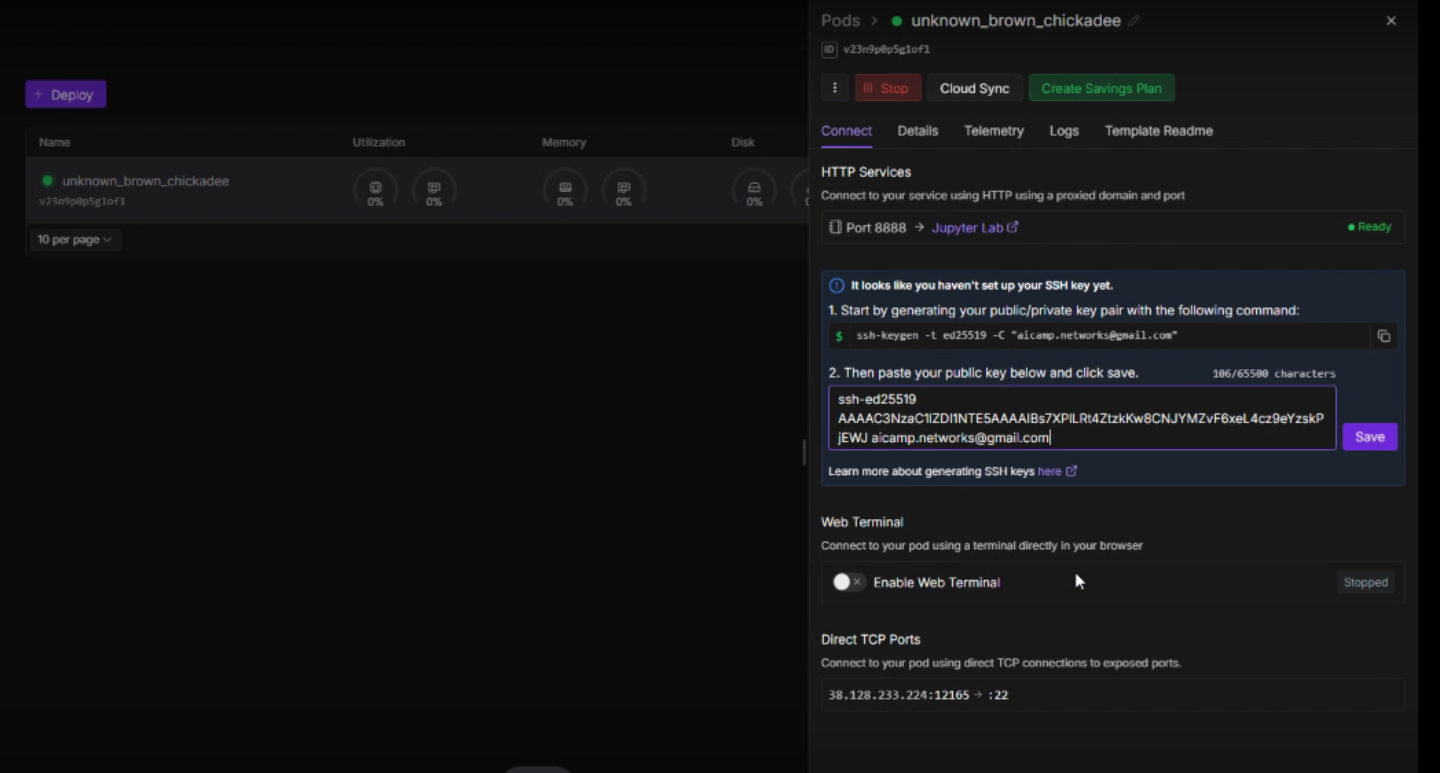

터미널(powershell)에서 상기 1번 실행

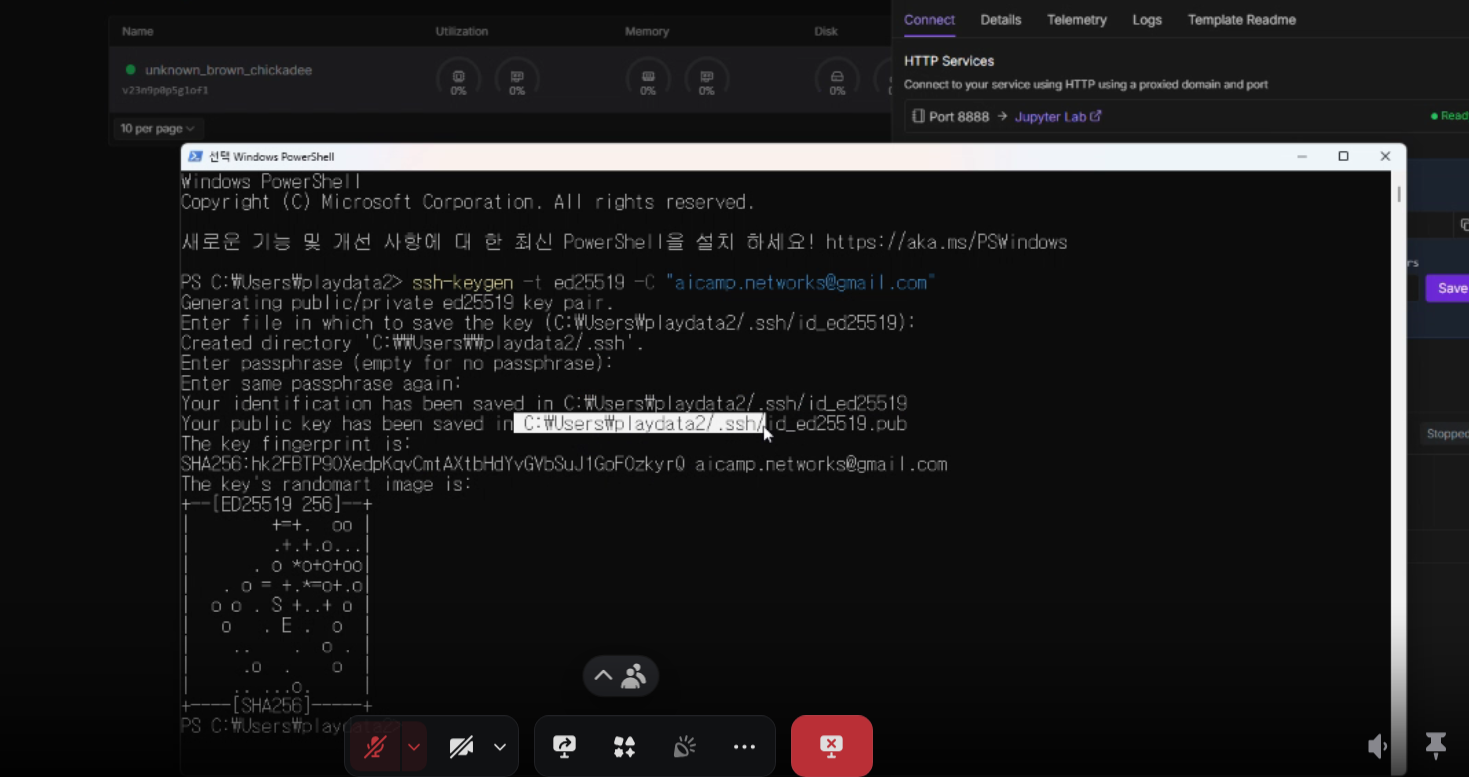

터미널에서 
상기 경로 확인 후 public key를 찾아서 복사하고 
런팟 페이지 2번에 붙여넣기 하고 save 하기

vscode에서 Remote - SSH 설치 

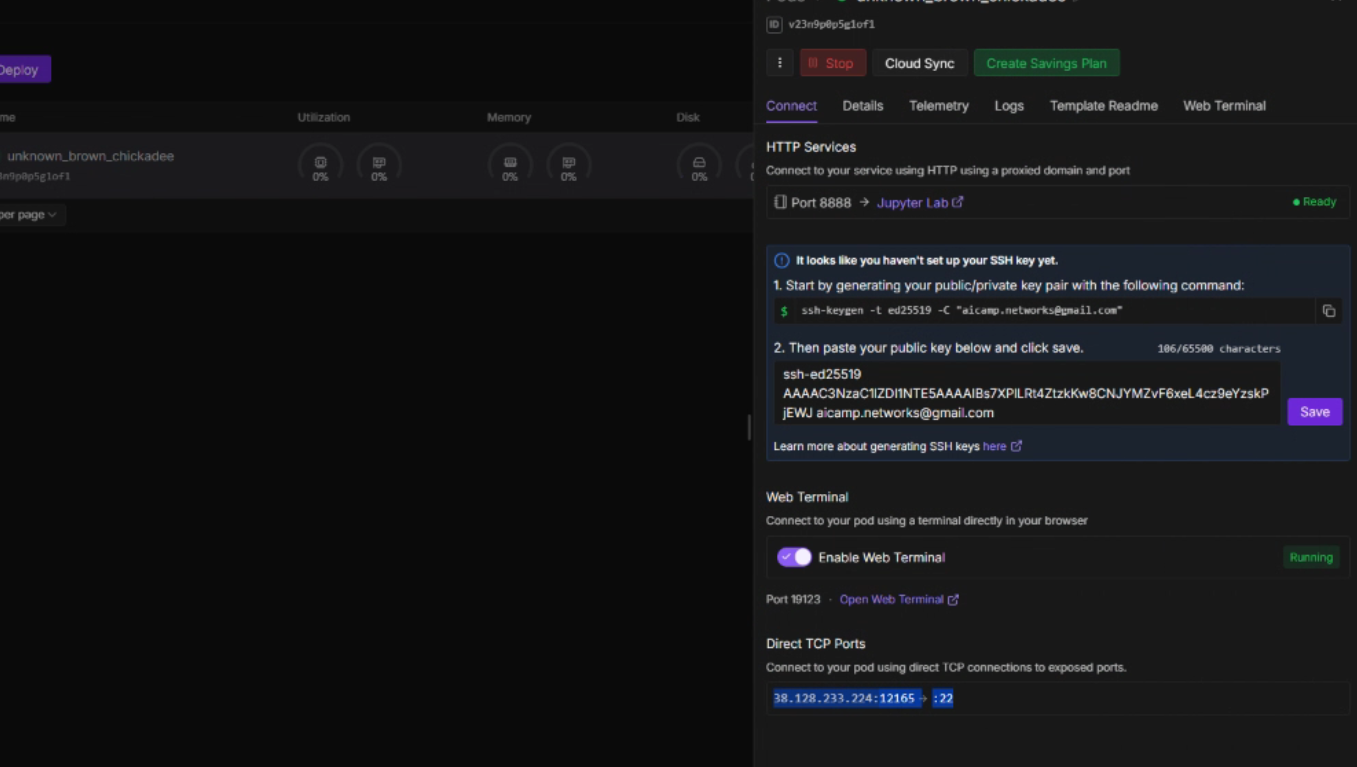

상기 IP 사용

